In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import shapiro
from scipy.stats import chisquare
import time

In [3]:
#Hourly 2D bottom currents
jan_jun = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/midnor/samp_2D_jan_jun.nc")
jun_aug = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/midnor/samp_2D_jun-aug.nc")
sep_dec = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/midnor/samp_2D_sep-dec.nc")

In [63]:
print(len(jan_jun.variables['time']))

4201


In [4]:
#Remove overlap
jan_jun = jan_jun.isel(time=slice(0, -360))  
jun_aug = jun_aug.isel(time=slice(0, -192))  

In [4]:
#Merge (not possible with this memory size.. Can do this later if necessary)
current_2019 = xr.concat([current_jan_jun, current_jun_aug, current_sep_dec], dim="time")

NameError: name 'current_jan_jun' is not defined

In [5]:
#Importing coral data
import pandas as pd

coral_data = pd.read_parquet('/cluster/home/maikents/midnor_total_coral_data_processed_v2.parquet')


In [30]:
print(len(coral_data))

941


In [19]:
#Histogram for bottom current speed
hor_res = jun_aug.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0,1)#(0, len(jun_aug.variables['time']))
coral_values_jun_aug = []
valid_coords_jun_aug = []
xc_max = jun_aug.variables['xc'].shape[0]
yc_max = jun_aug.variables['yc'].shape[0]
for time in range(t_start, t_stop):
        for x, y in zip(coral_data['x']/hor_res, coral_data['y']/hor_res):
            x = np.clip(np.round(coral_data['x']/hor_res).astype(int), 0, xc_max-1)
            y = np.clip(np.round(coral_data['y']/hor_res).astype(int), 0, yc_max-1)
            value = np.sqrt(jun_aug.variables['u-bottom'][time, y, x]**2 + jun_aug.variables['v-bottom'][time, y, x]**2)
            if not np.ma.is_masked(value):
                coral_values_jun_aug.append(value)
    
                    


In [44]:
print(len(jun_aug.variables['time']))

2014


In [18]:
print(list(jan_jun.variables))

['time', 'grid_mapping', 'LayerDepths', 'xc', 'yc', 'zc', 'depth', 'DXxDYy', 'gridLats', 'gridLons', 'u_velocity', 'v_velocity', 'temperature', 'salinity', 'elevation', 'u-wind', 'v-wind', 'u-bottom', 'v-bottom', 'ice_thickness', 'ice_compactness', 'u_ice', 'v_ice', 'salinity_ice', 'ice_melt_rate', 'ice_prod_rate', 'IceVFluxX', 'IceVFluxY', 'IceAFluxX', 'IceAFluxY']


In [17]:
import time
import numpy as np

hor_res = jun_aug.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0, 2014)  # (0, len(jun_aug.variables['time']))
coral_values_jun_aug = []
valid_coords_jun_aug = []
xc_max = jun_aug.variables['xc'].shape[0]
yc_max = jun_aug.variables['yc'].shape[0]

timing_results = []

start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:
            value = np.sqrt(jun_aug.variables['u-bottom'][time_idx, y, x]**2 +
                            jun_aug.variables['v-bottom'][time_idx, y, x]**2)
            
            #print(f"Point {i}: (x={x}, y={y}) -> Current Speed: {value:.6f}")

            if not np.ma.is_masked(value):
                coral_values_jun_aug.append(value)
                #print(f"Value at ({x}, {y}) added: {value:.6f}")
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()
    #print(f"Finished timestep {time_idx} in {end_time - start_time:.6f} seconds")

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 0 to 2013
Grid size: xc_max=950, yc_max=555

Total execution time: 1224.079378 seconds
Time step 0, Point 0 (x=705, y=179) - 0.152515 sec
Time step 0, Point 1 (x=612, y=44) - 0.000907 sec
Time step 0, Point 2 (x=528, y=176) - 0.000705 sec
Time step 0, Point 3 (x=637, y=157) - 0.000659 sec
Time step 0, Point 4 (x=586, y=182) - 0.000638 sec
Time step 0, Point 5 (x=744, y=138) - 0.000660 sec
Time step 0, Point 6 (x=582, y=113) - 0.000630 sec
Time step 0, Point 7 (x=631, y=169) - 0.000621 sec
Time step 0, Point 8 (x=584, y=71) - 0.000631 sec
Time step 0, Point 9 (x=571, y=179) - 0.000617 sec


In [18]:
#Convert list to numpy array for easier manipulation
coral_values_jun_aug = np.array(coral_values_jun_aug)


In [50]:
print(len(coral_values_jun_aug))

1895174


In [19]:
current_speed_df = pd.DataFrame({'current speed jun_aug': coral_values_jun_aug})
#current_speed_df.to_csv("coral_values_jun_aug.csv", index=False)

In [55]:
print(len(jan_jun.variables['time']))

3481


In [20]:
hor_res = jan_jun.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0, 2000)  # (0, len(jun_aug.variables['time']))
coral_values_jan_jun = []
valid_coords_jan_jun = []
xc_max = jan_jun.variables['xc'].shape[0]
yc_max = jan_jun.variables['yc'].shape[0]

timing_results = []

start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:
            value = np.sqrt(jan_jun.variables['u-bottom'][time_idx, y, x]**2 +
                            jan_jun.variables['v-bottom'][time_idx, y, x]**2)
            
            #print(f"Point {i}: (x={x}, y={y}) -> Current Speed: {value:.6f}")

            if not np.ma.is_masked(value):
                coral_values_jan_jun.append(value)
                #print(f"Value at ({x}, {y}) added: {value:.6f}")
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()
    #print(f"Finished timestep {time_idx} in {end_time - start_time:.6f} seconds")

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 0 to 1999
Grid size: xc_max=950, yc_max=555

Total execution time: 1218.976203 seconds
Time step 0, Point 0 (x=705, y=179) - 0.231130 sec
Time step 0, Point 1 (x=612, y=44) - 0.000937 sec
Time step 0, Point 2 (x=528, y=176) - 0.000724 sec
Time step 0, Point 3 (x=637, y=157) - 0.000698 sec
Time step 0, Point 4 (x=586, y=182) - 0.000943 sec
Time step 0, Point 5 (x=744, y=138) - 0.000696 sec
Time step 0, Point 6 (x=582, y=113) - 0.000685 sec
Time step 0, Point 7 (x=631, y=169) - 0.000728 sec
Time step 0, Point 8 (x=584, y=71) - 0.000715 sec
Time step 0, Point 9 (x=571, y=179) - 0.000610 sec


In [23]:
hor_res = jan_jun.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (2000, 3481)  # (0, len(jun_aug.variables['time']))
coral_values_jan_jun2 = []
valid_coords_jan_jun2 = []
xc_max = jan_jun.variables['xc'].shape[0]
yc_max = jan_jun.variables['yc'].shape[0]

timing_results = []

start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:
            value = np.sqrt(jan_jun.variables['u-bottom'][time_idx, y, x]**2 +
                            jan_jun.variables['v-bottom'][time_idx, y, x]**2)
            
            #print(f"Point {i}: (x={x}, y={y}) -> Current Speed: {value:.6f}")

            if not np.ma.is_masked(value):
                coral_values_jan_jun.append(value)
                #print(f"Value at ({x}, {y}) added: {value:.6f}")
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()
    #print(f"Finished timestep {time_idx} in {end_time - start_time:.6f} seconds")

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 2000 to 3480
Grid size: xc_max=950, yc_max=555

Total execution time: 888.307989 seconds
Time step 2000, Point 0 (x=705, y=179) - 0.059961 sec
Time step 2000, Point 1 (x=612, y=44) - 0.000893 sec
Time step 2000, Point 2 (x=528, y=176) - 0.000791 sec
Time step 2000, Point 3 (x=637, y=157) - 0.000696 sec
Time step 2000, Point 4 (x=586, y=182) - 0.000618 sec
Time step 2000, Point 5 (x=744, y=138) - 0.000625 sec
Time step 2000, Point 6 (x=582, y=113) - 0.003541 sec
Time step 2000, Point 7 (x=631, y=169) - 0.000621 sec
Time step 2000, Point 8 (x=584, y=71) - 0.000640 sec
Time step 2000, Point 9 (x=571, y=179) - 0.000626 sec


In [21]:
print(len(sep_dec.variables['time']))

2928


In [24]:
hor_res = sep_dec.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0, 2928)  # (0, len(jun_aug.variables['time']))
coral_values_sep_dec = []
valid_coords_sep_dec = []
xc_max = sep_dec.variables['xc'].shape[0]
yc_max = sep_dec.variables['yc'].shape[0]

timing_results = []

start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:
            value = np.sqrt(sep_dec.variables['u-bottom'][time_idx, y, x]**2 +
                            sep_dec.variables['v-bottom'][time_idx, y, x]**2)
            
            #print(f"Point {i}: (x={x}, y={y}) -> Current Speed: {value:.6f}")

            if not np.ma.is_masked(value):
                coral_values_sep_dec.append(value)
                #print(f"Value at ({x}, {y}) added: {value:.6f}")
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()
    #print(f"Finished timestep {time_idx} in {end_time - start_time:.6f} seconds")

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 0 to 2927
Grid size: xc_max=950, yc_max=555

Total execution time: 1765.210707 seconds
Time step 0, Point 0 (x=705, y=179) - 0.013543 sec
Time step 0, Point 1 (x=612, y=44) - 0.000945 sec
Time step 0, Point 2 (x=528, y=176) - 0.000737 sec
Time step 0, Point 3 (x=637, y=157) - 0.000675 sec
Time step 0, Point 4 (x=586, y=182) - 0.000672 sec
Time step 0, Point 5 (x=744, y=138) - 0.000714 sec
Time step 0, Point 6 (x=582, y=113) - 0.000647 sec
Time step 0, Point 7 (x=631, y=169) - 0.000617 sec
Time step 0, Point 8 (x=584, y=71) - 0.000625 sec
Time step 0, Point 9 (x=571, y=179) - 0.000620 sec


In [26]:
coral_values_jan_jun_flat = np.ravel(coral_values_jan_jun)  # Flattening the first array
coral_values_jun_aug_flat = np.ravel(coral_values_jun_aug)  # Flattening the second array
print(len(coral_values_jun_aug_flat))
# Concatenate the flattened arrays
all_current_speeds = np.concatenate((coral_values_jan_jun_flat, coral_values_jun_aug_flat))

# Create DataFrame with one column
current_speed_df = pd.DataFrame({'current speeds': all_current_speeds})

# Save to CSV
#current_speed_df.to_csv("coral_values.csv", index=False)

1895174


In [27]:
coral_values_jan_jun2_flat = np.ravel(coral_values_jan_jun2)
all_current_speeds = np.concatenate((coral_values_jan_jun_flat, coral_values_jun_aug_flat, coral_values_jan_jun2_flat))
current_speed_df = pd.DataFrame({'current speeds': all_current_speeds})
#current_speed_df.to_csv("coral_values.csv", index=False)

In [28]:
coral_values_sep_dec_flat = np.ravel(coral_values_sep_dec)
all_current_speeds = np.concatenate((coral_values_jan_jun_flat, coral_values_jan_jun2_flat, coral_values_jun_aug_flat, coral_values_sep_dec_flat))
current_speed_df = pd.DataFrame({'current speeds': all_current_speeds})
#current_speed_df.to_csv("coral_values.csv", index=False)

In [29]:
current_speeds = current_speed_df['current speeds'].dropna().values
current_speed_df.to_csv("current_speed_hourly.csv", index=False)

In [ ]:
hor_res = jan_jun.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (2001, 3481)  # (0, len(jun_aug.variables['time']))
coral_values_jan_jun2 = []
valid_coords_jan_jun2 = []
xc_max = jan_jun.variables['xc'].shape[0]
yc_max = jan_jun.variables['yc'].shape[0]

timing_results = []
c
start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:
            value = np.sqrt(jan_jun.variables['u-bottom'][time_idx, y, x]**2 +
                            jan_jun.variables['v-bottom'][time_idx, y, x]**2)
            
            #print(f"Point {i}: (x={x}, y={y}) -> Current Speed: {value:.6f}")

            if not np.ma.is_masked(value):
                coral_values_jan_jun2.append(value)
                #print(f"Value at ({x}, {y}) added: {value:.6f}")
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()
    #print(f"Finished timestep {time_idx} in {end_time - start_time:.6f} seconds")

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

In [81]:
# Calculate statistics for coral values
if 'current speeds' not in current_speed_df.columns:
    print("Error: 'current speeds' column not found in CSV!")
else:
    # Drop NaNs and convert to NumPy array
    current_speeds = current_speed_df['current speeds'].dropna().values

    # Check for empty array
    if len(current_speeds) == 0:
        print("Error: current_speeds array is empty after dropping NaNs!")
    else:
        # Compute statistics
        statistics = {
            'mean': np.float32(np.mean(current_speeds)),
            'max': np.float32(np.max(current_speeds)),
            'min': np.float32(np.min(current_speeds)),
            '90th_percentile': np.float32(np.percentile(current_speeds, 90)),
            '10th_percentile': np.float32(np.percentile(current_speeds, 10))
        }

        print("Statistics for current speed:", statistics)

Statistics for current speed: {'mean': np.float32(0.09981488), 'max': np.float32(0.7515798), 'min': np.float32(0.0), '90th_percentile': np.float32(0.19479178), '10th_percentile': np.float32(0.028968481)}


In [82]:
#Determine the bin edges for the histograms
bin_edges = np.histogram_bin_edges(current_speeds, bins=20)

In [ ]:
np.savetxt("bin_edges.csv", bin_edges, delimiter=",")


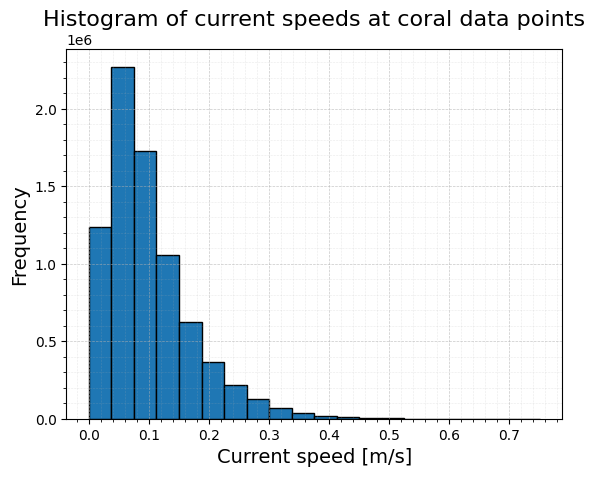

In [86]:
#Plot histogram of the current speeds
plt.hist(current_speeds, bins=bin_edges, edgecolor='black')
plt.xlabel('Current speed [m/s]', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Histogram of current speeds at coral data points', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Main grid
plt.minorticks_on()  # Enable minor ticks
plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)  # Finer minor grid

plt.savefig(f'/cluster/home/maikents/current_speed_histogram_coral_points_jun_aug.png')
 
plt.show()

In [7]:
midnor_2019 = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc")


In [8]:
print(list(midnor_2019.variables))

['time', 'grid_mapping', 'LayerDepths', 'xc', 'yc', 'zc', 'depth', 'DXxDYy', 'u_velocity', 'v_velocity', 'elevation', 'temperature', 'salinity', 'ice_thickness', 'ice_compactness', 'salinity_ice']


In [5]:
print(midnor_2019.variables['u_velocity'])

<xarray.Variable (time: 365, zc: 50, yc: 555, xc: 950)> Size: 38GB
[9622312500 values with dtype=float32]
Attributes:
    units:         m/s
    cell_methods:  time: mean


In [9]:
import time

hor_res = midnor_2019.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0, len(midnor_2019.variables['time']))
coral_values_midnor_2019 = []
valid_coords_midnor_2019 = []
xc_max = midnor_2019.variables['xc'].shape[0]
yc_max = midnor_2019.variables['yc'].shape[0]
zc = midnor_2019.variables['LayerDepths'][:]
cumulative_depth = np.cumsum(zc, axis=0)
timing_results = []

start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:

            depth_at_point = midnor_2019.variables['depth'][int(y), int(x)]
            layer_index = np.searchsorted(cumulative_depth, depth_at_point)

            value = np.sqrt(midnor_2019.variables['u_velocity'][time_idx, layer_index, int(y), int(x)]**2 + midnor_2019.variables['v_velocity'][time_idx, layer_index, int(y), int(x)]**2)

            if not np.ma.is_masked(value):
                coral_values_midnor_2019.append(value)
                #print(f"Value at ({x}, {y}) added: {value:.6f}")
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()
    #print(f"Finished timestep {time_idx} in {end_time - start_time:.6f} seconds")

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 0 to 364
Grid size: xc_max=950, yc_max=555

Total execution time: 4497.307102 seconds
Time step 0, Point 0 (x=705, y=179) - 3.014640 sec
Time step 0, Point 1 (x=612, y=44) - 0.001657 sec
Time step 0, Point 2 (x=528, y=176) - 0.001130 sec
Time step 0, Point 3 (x=637, y=157) - 0.001061 sec
Time step 0, Point 4 (x=586, y=182) - 0.000988 sec
Time step 0, Point 5 (x=744, y=138) - 0.001015 sec
Time step 0, Point 6 (x=582, y=113) - 0.000973 sec
Time step 0, Point 7 (x=631, y=169) - 0.001024 sec
Time step 0, Point 8 (x=584, y=71) - 0.000972 sec
Time step 0, Point 9 (x=571, y=179) - 0.001032 sec


In [9]:
physstates_2d = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/midnor/samp_2D_jan_jun.nc")

gridLons = physstates_2d.variables['gridLons']

In [10]:
#midnor stat eastness

import time

hor_res = midnor_2019.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0, len(midnor_2019.variables['time']))
coral_values_midnor_2019 = []
valid_coords_midnor_2019 = []
xc_max = midnor_2019.variables['xc'].shape[0]
yc_max = midnor_2019.variables['yc'].shape[0]
zc = midnor_2019.variables['LayerDepths'][:]
cumulative_depth = np.cumsum(zc, axis=0)
timing_results = []
longitude_of_projection_origin = midnor_2019.grid_mapping.attrs['longitude_of_projection_origin']

start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:

            depth_at_point = midnor_2019.variables['depth'][int(y), int(x)]
            layer_index = np.searchsorted(cumulative_depth, depth_at_point)

            #value = np.sqrt(midnor_2019.variables['u_velocity'][time_idx, layer_index, int(y), int(x)]**2 + midnor_2019.variables['v_velocity'][time_idx, layer_index, int(y), int(x)]**2)
            longitude_at_point = gridLons[int(y),int(x)]
            theta = longitude_at_point - longitude_of_projection_origin
            eastward_velocity = midnor_2019.variables['u_velocity'][time_idx, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta)) - midnor_2019.variables['v_velocity'][time_idx, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta))
            northward_velocity = midnor_2019.variables['u_velocity'][time_idx, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta)) + midnor_2019.variables['v_velocity'][time_idx, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta))
            aspect = np.arctan2(eastward_velocity, northward_velocity)
            value = np.sin(aspect)
            
            if not np.ma.is_masked(value):
                coral_values_midnor_2019.append(value)
                #print(f"Value at ({x}, {y}) added: {value:.6f}")
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()
    #print(f"Finished timestep {time_idx} in {end_time - start_time:.6f} seconds")

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 0 to 364
Grid size: xc_max=950, yc_max=555

Total execution time: 4270.979698 seconds
Time step 0, Point 0 (x=705, y=179) - 1.971335 sec
Time step 0, Point 1 (x=612, y=44) - 0.013701 sec
Time step 0, Point 2 (x=528, y=176) - 0.013569 sec
Time step 0, Point 3 (x=637, y=157) - 0.008169 sec
Time step 0, Point 4 (x=586, y=182) - 0.002679 sec
Time step 0, Point 5 (x=744, y=138) - 0.005327 sec
Time step 0, Point 6 (x=582, y=113) - 0.008121 sec
Time step 0, Point 7 (x=631, y=169) - 0.003013 sec
Time step 0, Point 8 (x=584, y=71) - 0.003419 sec
Time step 0, Point 9 (x=571, y=179) - 0.002124 sec


In [23]:
#midnor depth

import time

hor_res = midnor_2019.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0, len(midnor_2019.variables['time']))
coral_values_midnor_2019 = []
valid_coords_midnor_2019 = []
xc_max = midnor_2019.variables['xc'].shape[0]
yc_max = midnor_2019.variables['yc'].shape[0]
zc = midnor_2019.variables['LayerDepths'][:]
cumulative_depth = np.cumsum(zc, axis=0)
timing_results = []

start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:

            depth_at_point = midnor_2019.variables['depth'][int(y), int(x)]
            layer_index = np.searchsorted(cumulative_depth, depth_at_point)

            
            value = layer_index
            
            if not np.ma.is_masked(value):
                coral_values_midnor_2019.append(value)
                #print(f"Value at ({x}, {y}) added: {value:.6f}")
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()
    #print(f"Finished timestep {time_idx} in {end_time - start_time:.6f} seconds")

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 0 to 364
Grid size: xc_max=950, yc_max=555

Total execution time: 77.056567 seconds
Time step 0, Point 0 (x=705, y=179) - 0.000494 sec
Time step 0, Point 1 (x=612, y=44) - 0.000318 sec
Time step 0, Point 2 (x=528, y=176) - 0.000271 sec
Time step 0, Point 3 (x=637, y=157) - 0.000253 sec
Time step 0, Point 4 (x=586, y=182) - 0.000254 sec
Time step 0, Point 5 (x=744, y=138) - 0.000265 sec
Time step 0, Point 6 (x=582, y=113) - 0.000240 sec
Time step 0, Point 7 (x=631, y=169) - 0.000234 sec
Time step 0, Point 8 (x=584, y=71) - 0.000240 sec
Time step 0, Point 9 (x=571, y=179) - 0.000308 sec


In [16]:
print(list(midnor_2019.variables))

['time', 'grid_mapping', 'LayerDepths', 'xc', 'yc', 'zc', 'depth', 'DXxDYy', 'u_velocity', 'v_velocity', 'elevation', 'temperature', 'salinity', 'ice_thickness', 'ice_compactness', 'salinity_ice']


In [19]:
print(list(midnor_2019.variables))

['time', 'grid_mapping', 'LayerDepths', 'xc', 'yc', 'zc', 'depth', 'DXxDYy', 'u_velocity', 'v_velocity', 'elevation', 'temperature', 'salinity', 'ice_thickness', 'ice_compactness', 'salinity_ice']


In [12]:
coral_values_midnor_2019_flat = np.ravel(coral_values_midnor_2019)
current_speed_midnor_2019 = pd.DataFrame({'current speeds': coral_values_midnor_2019_flat})


In [24]:
coral_values_midnor_2019_flat = np.ravel(coral_values_midnor_2019)
depth_midnor_2019 = pd.DataFrame({'depth': coral_values_midnor_2019_flat})


In [13]:
if 'current speeds' not in current_speed_midnor_2019.columns:
    print("Error: 'current speeds' column not found in CSV!")
else:
    # Drop NaNs and convert to NumPy array
    current_speeds_midnor = current_speed_midnor_2019['current speeds'].dropna().values

    # Check for empty array
    if len(current_speeds_midnor) == 0:
        print("Error: current_speeds array is empty after dropping NaNs!")
    else:
        # Compute statistics
        statistics_midnor = {
            'mean': np.float32(np.mean(current_speeds_midnor)),
            'max': np.float32(np.max(current_speeds_midnor)),
            'min': np.float32(np.min(current_speeds_midnor)),
            '90th_percentile': np.float32(np.percentile(current_speeds_midnor, 90)),
            '10th_percentile': np.float32(np.percentile(current_speeds_midnor, 10))
        }

        print("Statistics for current speed:", statistics_midnor)

Statistics for current speed: {'mean': np.float32(0.08369906), 'max': np.float32(0.66142267), 'min': np.float32(0.0), '90th_percentile': np.float32(0.17554247), '10th_percentile': np.float32(0.011638081)}


In [25]:
if 'depth' not in depth_midnor_2019.columns:
    print("Error: 'depth' column not found in CSV!")
else:
    # Drop NaNs and convert to NumPy array
    depth_midnor = depth_midnor_2019['depth'].dropna().values

    # Check for empty array
    if len(depth_midnor) == 0:
        print("Error: depth array is empty after dropping NaNs!")
    else:
        # Compute statistics
        statistics_midnor = {
            'mean': np.float32(np.mean(depth_midnor)),
            'max': np.float32(np.max(depth_midnor)),
            'min': np.float32(np.min(depth_midnor)),
            '90th_percentile': np.float32(np.percentile(depth_midnor, 90)),
            '10th_percentile': np.float32(np.percentile(depth_midnor, 10))
        }

        print("Statistics for depth:", statistics_midnor)

Statistics for depth: {'mean': np.float32(19.069075), 'max': np.float32(35.0), 'min': np.float32(0.0), '90th_percentile': np.float32(23.0), '10th_percentile': np.float32(15.0)}


In [26]:
bin_edges = np.histogram_bin_edges(depth_midnor, bins=20)

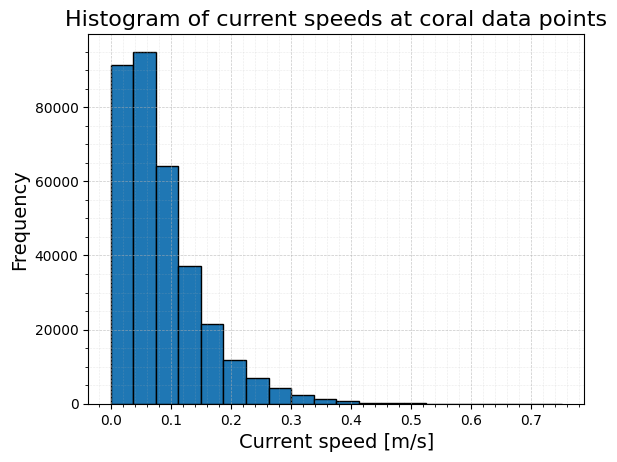

In [103]:
#Plot histogram of the current speeds midnor
plt.hist(current_speeds_midnor, bins=bin_edges, edgecolor='black')
plt.xlabel('Current speed [m/s]', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Histogram of current speeds at coral data points', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Main grid
plt.minorticks_on()  # Enable minor ticks
plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)  # Finer minor grid

plt.savefig(f'/cluster/home/maikents/current_speed_histogram_coral_points_midnor.png')
 
plt.show()

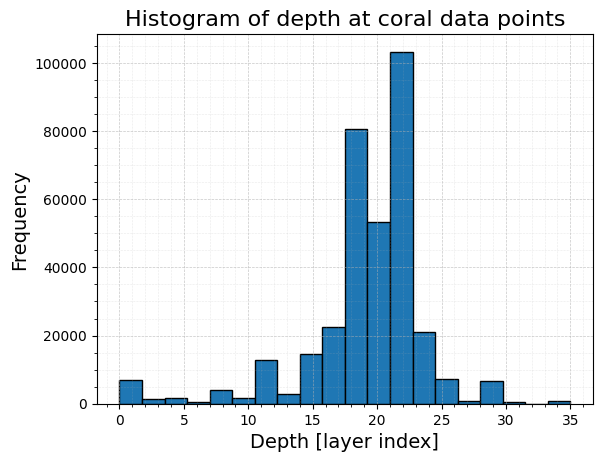

In [28]:
#Plot histogram of the depth midnor
plt.hist(depth_midnor, bins=bin_edges, edgecolor='black')
plt.xlabel('Depth [layer index]', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Histogram of depth at coral data points', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Main grid
plt.minorticks_on()  # Enable minor ticks
plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)  # Finer minor grid

plt.savefig(f'/cluster/home/maikents/depth_histogram_coral_points_midnor.png')
 
plt.show()

In [30]:
#Calculating statistical significance of results

hourly_current_speed = pd.read_csv("current_speed_hourly.csv")
print(hourly_current_speed.head())
print(current_speed_midnor_2019.head())     


   current speeds
0        0.051808
1             NaN
2        0.014002
3        0.117651
4        0.158672
   current speeds
0        0.051810
1             NaN
2        0.013868
3        0.077517
4        0.000000


In [32]:
hourly_current_speed = hourly_current_speed.dropna()
current_speed_midnor_2019 = current_speed_midnor_2019.dropna()

In [34]:
stat_hourly, p_hourly = shapiro(hourly_current_speed['current speeds']) 
print(f"Hourly current speed: p-value = {p_hourly}")

stat_24, p_24 = shapiro(current_speed_midnor_2019['current speeds'])  
print(f"24-Hourly current speed: p-value = {p_24}")

#If p > 0.05, the data is likely normally distributed.
#If p ≤ 0.05, the data is not normally distributed.

Hourly current speed: p-value = 1.0848101384792317e-169
24-Hourly current speed: p-value = 1.779195775524983e-141


/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 336895.
  res = hypotest_fun_out(*samples, **kwds)


In [38]:
from scipy.stats import mannwhitneyu

stat, p_val = mannwhitneyu(hourly_current_speed['current speeds'], current_speed_midnor_2019['current speeds'], alternative='two-sided')
print(f"Mann-Whitney U test: U = {stat}, p = {p_val}")


Mann-Whitney U test: U = 1517597563748.0, p = 0.0


In [41]:
print(current_speed_midnor_2019['current speeds'].head())

0    0.051810
2    0.013868
3    0.077517
4    0.000000
5    0.024589
Name: current speeds, dtype: float32


In [43]:
print(hourly_current_speed['current speeds'].head())

0    0.051808
2    0.014002
3    0.117651
4    0.158672
5    0.024662
Name: current speeds, dtype: float64


In [5]:
import pandas as pd

In [6]:
hourly = pd.read_csv("current_speed_hourly.csv")
daily = pd.read_csv("current_speed_24hourly.csv")

In [7]:
import scipy.stats as stats


In [53]:
print(hourly.head())

   current speeds
0        0.051808
1             NaN
2        0.014002
3        0.117651
4        0.158672


In [9]:
#Kolmogorov-Smirnov (KS) test

ks_stat, p_value = stats.ks_2samp(hourly["current speeds"].dropna(), daily["current speeds"].dropna())
print(f"p-value: {p_value:.16f}") 

print(f"KS Statistic: {ks_stat}")
print(f"p-value: {p_value}")

alpha = 0.05  #Significance level
if p_value < alpha:
    print("Reject the null hypothesis: The distributions are different.")
else:
    print("Fail to reject the null hypothesis: The distributions are similar.")


p-value: 0.0000000000000000
KS Statistic: 0.11352851307582354
p-value: 0.0
Reject the null hypothesis: The distributions are different.


In [ ]:
#Anderson-Darling Test
result = stats.anderson_ksamp([hourly["current speeds"].dropna(), daily["current speeds"].dropna()], method=stats.PermutationMethod())

print(f"AD Statistic: {result.statistic:.16f}")
print(f"p-value: {result.pvalue:.16f}")  
alpha = 0.05  # Significance level
if result.pvalue < alpha:
    print("Reject the null hypothesis: The distributions are different.")
else:
    print("Fail to reject the null hypothesis: The distributions are similar.")


In [8]:
import scipy.stats as stats

#Mann-Whitney U Test
u_stat, p_value = stats.mannwhitneyu(hourly["current speeds"].dropna(), daily["current speeds"].dropna(), alternative="two-sided")

print(f"U Statistic: {u_stat}")
print(f"P-value: {p_value:.16f}")

alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: The distributions are different.")
else:
    print("Fail to reject the null hypothesis: The distributions are similar.")


U Statistic: 1517600093209.5
P-value: 0.0000000000000000
Reject the null hypothesis: The distributions are different.


In [11]:
print(list(jan_jun.variables))
#jun_aug 
#sep_dec

['time', 'grid_mapping', 'LayerDepths', 'xc', 'yc', 'zc', 'depth', 'DXxDYy', 'gridLats', 'gridLons', 'u_velocity', 'v_velocity', 'temperature', 'salinity', 'elevation', 'u-wind', 'v-wind', 'u-bottom', 'v-bottom', 'ice_thickness', 'ice_compactness', 'u_ice', 'v_ice', 'salinity_ice', 'ice_melt_rate', 'ice_prod_rate', 'IceVFluxX', 'IceVFluxY', 'IceAFluxX', 'IceAFluxY']


In [9]:
#Statistical northness
hor_res = jan_jun.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0, 2000)  # (0, len(jun_aug.variables['time']))
coral_values_jan_jun = []
valid_coords_jan_jun = []
xc_max = jan_jun.variables['xc'].shape[0]
yc_max = jan_jun.variables['yc'].shape[0]
longitude_of_projection_origin = jan_jun.grid_mapping.attrs['longitude_of_projection_origin']

timing_results = []
start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:
            longitude_at_point = jan_jun.variables['gridLons'][y,x]
            theta = longitude_at_point - longitude_of_projection_origin
            eastward_velocity = jan_jun.variables['u_velocity'][time_idx, y, x] * np.cos(np.deg2rad(theta)) - jan_jun.variables['v_velocity'][time_idx, y, x] * np.sin(np.deg2rad(theta))
            northward_velocity = jan_jun.variables['u_velocity'][time_idx, y, x] * np.sin(np.deg2rad(theta)) + jan_jun.variables['v_velocity'][time_idx, y, x] * np.cos(np.deg2rad(theta))
            aspect = np.arctan2(eastward_velocity, northward_velocity)
                    #if variable_name == 'statistical_eastness':
                        #value = np.sin(aspect)
    
            value = np.cos(aspect)
               
            if not np.ma.is_masked(value):
                coral_values_jan_jun.append(value)
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 0 to 1999
Grid size: xc_max=950, yc_max=555

Total execution time: 2998.187395 seconds
Time step 0, Point 0 (x=705, y=179) - 1.428796 sec
Time step 0, Point 1 (x=612, y=44) - 0.021123 sec
Time step 0, Point 2 (x=528, y=176) - 0.016312 sec
Time step 0, Point 3 (x=637, y=157) - 0.008257 sec
Time step 0, Point 4 (x=586, y=182) - 0.002076 sec
Time step 0, Point 5 (x=744, y=138) - 0.005856 sec
Time step 0, Point 6 (x=582, y=113) - 0.007947 sec
Time step 0, Point 7 (x=631, y=169) - 0.002037 sec
Time step 0, Point 8 (x=584, y=71) - 0.002144 sec
Time step 0, Point 9 (x=571, y=179) - 0.001559 sec


In [6]:
#Statistical eastness
hor_res = jan_jun.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0, 2000)  # (0, len(jun_aug.variables['time']))
coral_values_jan_jun = []
valid_coords_jan_jun = []
xc_max = jan_jun.variables['xc'].shape[0]
yc_max = jan_jun.variables['yc'].shape[0]
longitude_of_projection_origin = jan_jun.grid_mapping.attrs['longitude_of_projection_origin']

timing_results = []
start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:
            longitude_at_point = jan_jun.variables['gridLons'][y,x]
            theta = longitude_at_point - longitude_of_projection_origin
            eastward_velocity = jan_jun.variables['u_velocity'][time_idx, y, x] * np.cos(np.deg2rad(theta)) - jan_jun.variables['v_velocity'][time_idx, y, x] * np.sin(np.deg2rad(theta))
            northward_velocity = jan_jun.variables['u_velocity'][time_idx, y, x] * np.sin(np.deg2rad(theta)) + jan_jun.variables['v_velocity'][time_idx, y, x] * np.cos(np.deg2rad(theta))
            aspect = np.arctan2(eastward_velocity, northward_velocity)
                    #if variable_name == 'statistical_eastness':
                        #value = np.sin(aspect)
    
            value = np.sin(aspect)
               
            if not np.ma.is_masked(value):
                coral_values_jan_jun.append(value)
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 0 to 1999
Grid size: xc_max=950, yc_max=555

Total execution time: 2942.299924 seconds
Time step 0, Point 0 (x=705, y=179) - 1.567925 sec
Time step 0, Point 1 (x=612, y=44) - 0.011883 sec
Time step 0, Point 2 (x=528, y=176) - 0.017376 sec
Time step 0, Point 3 (x=637, y=157) - 0.033437 sec
Time step 0, Point 4 (x=586, y=182) - 0.002362 sec
Time step 0, Point 5 (x=744, y=138) - 0.005695 sec
Time step 0, Point 6 (x=582, y=113) - 0.007921 sec
Time step 0, Point 7 (x=631, y=169) - 0.002275 sec
Time step 0, Point 8 (x=584, y=71) - 0.002474 sec
Time step 0, Point 9 (x=571, y=179) - 0.001581 sec


In [6]:
#Statistical northness
hor_res = jan_jun.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (2001, len(jan_jun.variables['time']))  # (0, len(jun_aug.variables['time']))
coral_values_jan_jun2 = []
valid_coords_jan_jun2 = []
xc_max = jan_jun.variables['xc'].shape[0]
yc_max = jan_jun.variables['yc'].shape[0]
longitude_of_projection_origin = jan_jun.grid_mapping.attrs['longitude_of_projection_origin']

timing_results = []
start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:
            longitude_at_point = jan_jun.variables['gridLons'][y,x]
            theta = longitude_at_point - longitude_of_projection_origin
            eastward_velocity = jan_jun.variables['u_velocity'][time_idx, y, x] * np.cos(np.deg2rad(theta)) - jan_jun.variables['v_velocity'][time_idx, y, x] * np.sin(np.deg2rad(theta))
            northward_velocity = jan_jun.variables['u_velocity'][time_idx, y, x] * np.sin(np.deg2rad(theta)) + jan_jun.variables['v_velocity'][time_idx, y, x] * np.cos(np.deg2rad(theta))
            aspect = np.arctan2(eastward_velocity, northward_velocity)
                    #if variable_name == 'statistical_eastness':
                        #value = np.sin(aspect)
    
            value = np.cos(aspect)
               
            if not np.ma.is_masked(value):
                coral_values_jan_jun2.append(value)
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 2001 to 3840
Grid size: xc_max=950, yc_max=555

Total execution time: 4751.304636 seconds
Time step 2001, Point 0 (x=705, y=179) - 0.072793 sec
Time step 2001, Point 1 (x=612, y=44) - 0.002924 sec
Time step 2001, Point 2 (x=528, y=176) - 0.002877 sec
Time step 2001, Point 3 (x=637, y=157) - 0.002855 sec
Time step 2001, Point 4 (x=586, y=182) - 0.002755 sec
Time step 2001, Point 5 (x=744, y=138) - 0.002770 sec
Time step 2001, Point 6 (x=582, y=113) - 0.002680 sec
Time step 2001, Point 7 (x=631, y=169) - 0.002771 sec
Time step 2001, Point 8 (x=584, y=71) - 0.002801 sec
Time step 2001, Point 9 (x=571, y=179) - 0.002706 sec


In [7]:
#Statistical eastness
hor_res = jan_jun.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (2001, len(jan_jun.variables['time']))  # (0, len(jun_aug.variables['time']))
coral_values_jan_jun2 = []
valid_coords_jan_jun2 = []
xc_max = jan_jun.variables['xc'].shape[0]
yc_max = jan_jun.variables['yc'].shape[0]
longitude_of_projection_origin = jan_jun.grid_mapping.attrs['longitude_of_projection_origin']

timing_results = []
start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:
            longitude_at_point = jan_jun.variables['gridLons'][y,x]
            theta = longitude_at_point - longitude_of_projection_origin
            eastward_velocity = jan_jun.variables['u_velocity'][time_idx, y, x] * np.cos(np.deg2rad(theta)) - jan_jun.variables['v_velocity'][time_idx, y, x] * np.sin(np.deg2rad(theta))
            northward_velocity = jan_jun.variables['u_velocity'][time_idx, y, x] * np.sin(np.deg2rad(theta)) + jan_jun.variables['v_velocity'][time_idx, y, x] * np.cos(np.deg2rad(theta))
            aspect = np.arctan2(eastward_velocity, northward_velocity)
                    #if variable_name == 'statistical_eastness':
                        #value = np.sin(aspect)
    
            value = np.sin(aspect)
               
            if not np.ma.is_masked(value):
                coral_values_jan_jun2.append(value)
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 2001 to 3840
Grid size: xc_max=950, yc_max=555

Total execution time: 2645.040694 seconds
Time step 2001, Point 0 (x=705, y=179) - 0.050116 sec
Time step 2001, Point 1 (x=612, y=44) - 0.001625 sec
Time step 2001, Point 2 (x=528, y=176) - 0.001626 sec
Time step 2001, Point 3 (x=637, y=157) - 0.001566 sec
Time step 2001, Point 4 (x=586, y=182) - 0.001546 sec
Time step 2001, Point 5 (x=744, y=138) - 0.001520 sec
Time step 2001, Point 6 (x=582, y=113) - 0.001549 sec
Time step 2001, Point 7 (x=631, y=169) - 0.001527 sec
Time step 2001, Point 8 (x=584, y=71) - 0.001521 sec
Time step 2001, Point 9 (x=571, y=179) - 0.001496 sec


In [11]:
#Statistical northness
hor_res = jun_aug.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0, len(jun_aug.variables['time']))  # (0, len(jun_aug.variables['time']))
coral_values_jun_aug = []
valid_coords_jun_aug = []
xc_max = jun_aug.variables['xc'].shape[0]
yc_max = jun_aug.variables['yc'].shape[0]
longitude_of_projection_origin = jun_aug.grid_mapping.attrs['longitude_of_projection_origin']

timing_results = []
start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:
            longitude_at_point = jun_aug.variables['gridLons'][y,x]
            theta = longitude_at_point - longitude_of_projection_origin
            eastward_velocity = jun_aug.variables['u_velocity'][time_idx, y, x] * np.cos(np.deg2rad(theta)) - jun_aug.variables['v_velocity'][time_idx, y, x] * np.sin(np.deg2rad(theta))
            northward_velocity = jun_aug.variables['u_velocity'][time_idx, y, x] * np.sin(np.deg2rad(theta)) + jun_aug.variables['v_velocity'][time_idx, y, x] * np.cos(np.deg2rad(theta))
            aspect = np.arctan2(eastward_velocity, northward_velocity)
                    #if variable_name == 'statistical_eastness':
                        #value = np.sin(aspect)
    
            value = np.cos(aspect)
               
            if not np.ma.is_masked(value):
                coral_values_jun_aug.append(value)
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 0 to 2013
Grid size: xc_max=950, yc_max=555

Total execution time: 2919.113083 seconds
Time step 0, Point 0 (x=705, y=179) - 0.725049 sec
Time step 0, Point 1 (x=612, y=44) - 0.019285 sec
Time step 0, Point 2 (x=528, y=176) - 0.023369 sec
Time step 0, Point 3 (x=637, y=157) - 0.004655 sec
Time step 0, Point 4 (x=586, y=182) - 0.002158 sec
Time step 0, Point 5 (x=744, y=138) - 0.009426 sec
Time step 0, Point 6 (x=582, y=113) - 0.004268 sec
Time step 0, Point 7 (x=631, y=169) - 0.001978 sec
Time step 0, Point 8 (x=584, y=71) - 0.002145 sec
Time step 0, Point 9 (x=571, y=179) - 0.001576 sec


In [8]:
#Statistical eastness
hor_res = jun_aug.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0, len(jun_aug.variables['time']))  # (0, len(jun_aug.variables['time']))
coral_values_jun_aug = []
valid_coords_jun_aug = []
xc_max = jun_aug.variables['xc'].shape[0]
yc_max = jun_aug.variables['yc'].shape[0]
longitude_of_projection_origin = jun_aug.grid_mapping.attrs['longitude_of_projection_origin']

timing_results = []
start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:
            longitude_at_point = jun_aug.variables['gridLons'][y,x]
            theta = longitude_at_point - longitude_of_projection_origin
            eastward_velocity = jun_aug.variables['u_velocity'][time_idx, y, x] * np.cos(np.deg2rad(theta)) - jun_aug.variables['v_velocity'][time_idx, y, x] * np.sin(np.deg2rad(theta))
            northward_velocity = jun_aug.variables['u_velocity'][time_idx, y, x] * np.sin(np.deg2rad(theta)) + jun_aug.variables['v_velocity'][time_idx, y, x] * np.cos(np.deg2rad(theta))
            aspect = np.arctan2(eastward_velocity, northward_velocity)
                    #if variable_name == 'statistical_eastness':
                        #value = np.sin(aspect)
    
            value = np.sin(aspect)
               
            if not np.ma.is_masked(value):
                coral_values_jun_aug.append(value)
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 0 to 2013
Grid size: xc_max=950, yc_max=555

Total execution time: 2937.174884 seconds
Time step 0, Point 0 (x=705, y=179) - 0.158154 sec
Time step 0, Point 1 (x=612, y=44) - 0.020588 sec
Time step 0, Point 2 (x=528, y=176) - 0.019535 sec
Time step 0, Point 3 (x=637, y=157) - 0.008413 sec
Time step 0, Point 4 (x=586, y=182) - 0.002284 sec
Time step 0, Point 5 (x=744, y=138) - 0.022266 sec
Time step 0, Point 6 (x=582, y=113) - 0.007945 sec
Time step 0, Point 7 (x=631, y=169) - 0.002251 sec
Time step 0, Point 8 (x=584, y=71) - 0.002342 sec
Time step 0, Point 9 (x=571, y=179) - 0.001483 sec


In [12]:
#Statistical northness
hor_res = sep_dec.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0, len(sep_dec.variables['time']))  # (0, len(jun_aug.variables['time']))
coral_values_sep_dec = []
valid_coords_sep_dec = []
xc_max = sep_dec.variables['xc'].shape[0]
yc_max = sep_dec.variables['yc'].shape[0]
longitude_of_projection_origin = sep_dec.grid_mapping.attrs['longitude_of_projection_origin']

timing_results = []
start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:
            longitude_at_point = sep_dec.variables['gridLons'][y,x]
            theta = longitude_at_point - longitude_of_projection_origin
            eastward_velocity = sep_dec.variables['u_velocity'][time_idx, y, x] * np.cos(np.deg2rad(theta)) - sep_dec.variables['v_velocity'][time_idx, y, x] * np.sin(np.deg2rad(theta))
            northward_velocity = sep_dec.variables['u_velocity'][time_idx, y, x] * np.sin(np.deg2rad(theta)) + sep_dec.variables['v_velocity'][time_idx, y, x] * np.cos(np.deg2rad(theta))
            aspect = np.arctan2(eastward_velocity, northward_velocity)
                    #if variable_name == 'statistical_eastness':
                        #value = np.sin(aspect)
    
            value = np.cos(aspect)
               
            if not np.ma.is_masked(value):
                coral_values_sep_dec.append(value)
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 0 to 2927
Grid size: xc_max=950, yc_max=555

Total execution time: 4203.052008 seconds
Time step 0, Point 0 (x=705, y=179) - 0.871257 sec
Time step 0, Point 1 (x=612, y=44) - 0.014750 sec
Time step 0, Point 2 (x=528, y=176) - 0.025443 sec
Time step 0, Point 3 (x=637, y=157) - 0.016691 sec
Time step 0, Point 4 (x=586, y=182) - 0.002038 sec
Time step 0, Point 5 (x=744, y=138) - 0.006026 sec
Time step 0, Point 6 (x=582, y=113) - 0.007938 sec
Time step 0, Point 7 (x=631, y=169) - 0.001947 sec
Time step 0, Point 8 (x=584, y=71) - 0.002097 sec
Time step 0, Point 9 (x=571, y=179) - 0.001510 sec


In [9]:
#Statistical eastness
hor_res = sep_dec.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0, len(sep_dec.variables['time']))  # (0, len(jun_aug.variables['time']))
coral_values_sep_dec = []
valid_coords_sep_dec = []
xc_max = sep_dec.variables['xc'].shape[0]
yc_max = sep_dec.variables['yc'].shape[0]
longitude_of_projection_origin = sep_dec.grid_mapping.attrs['longitude_of_projection_origin']

timing_results = []
start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:
            longitude_at_point = sep_dec.variables['gridLons'][y,x]
            theta = longitude_at_point - longitude_of_projection_origin
            eastward_velocity = sep_dec.variables['u_velocity'][time_idx, y, x] * np.cos(np.deg2rad(theta)) - sep_dec.variables['v_velocity'][time_idx, y, x] * np.sin(np.deg2rad(theta))
            northward_velocity = sep_dec.variables['u_velocity'][time_idx, y, x] * np.sin(np.deg2rad(theta)) + sep_dec.variables['v_velocity'][time_idx, y, x] * np.cos(np.deg2rad(theta))
            aspect = np.arctan2(eastward_velocity, northward_velocity)
                    #if variable_name == 'statistical_eastness':
                        #value = np.sin(aspect)
    
            value = np.sin(aspect)
               
            if not np.ma.is_masked(value):
                coral_values_sep_dec.append(value)
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 0 to 2927
Grid size: xc_max=950, yc_max=555

Total execution time: 4286.512665 seconds
Time step 0, Point 0 (x=705, y=179) - 0.161357 sec
Time step 0, Point 1 (x=612, y=44) - 0.058589 sec
Time step 0, Point 2 (x=528, y=176) - 0.011677 sec
Time step 0, Point 3 (x=637, y=157) - 0.025189 sec
Time step 0, Point 4 (x=586, y=182) - 0.002242 sec
Time step 0, Point 5 (x=744, y=138) - 0.005806 sec
Time step 0, Point 6 (x=582, y=113) - 0.014217 sec
Time step 0, Point 7 (x=631, y=169) - 0.074662 sec
Time step 0, Point 8 (x=584, y=71) - 0.008112 sec
Time step 0, Point 9 (x=571, y=179) - 0.001552 sec


In [13]:
coral_values_jan_jun_flat = np.ravel(coral_values_jan_jun)  # Flattening the first array
coral_values_jan_jun2_flat = np.ravel(coral_values_jan_jun2)  # Flattening the second array
coral_values_jun_aug_flat = np.ravel(coral_values_jun_aug)  # Flattening the second array
coral_values_sep_dec_flat = np.ravel(coral_values_sep_dec)  # Flattening the second array

# Concatenate the flattened arrays
all_stat_northness = np.concatenate((coral_values_jan_jun_flat, coral_values_jan_jun2_flat, coral_values_jun_aug_flat, coral_values_sep_dec_flat))

# Create DataFrame with one column
stat_northness_df = pd.DataFrame({'statistical northness': all_stat_northness})

# Save to CSV
stat_northness_df.to_csv("statistical_northness_hourly.csv", index=False)

In [11]:
coral_values_jan_jun_flat = np.ravel(coral_values_jan_jun)  # Flattening the first array
coral_values_jan_jun2_flat = np.ravel(coral_values_jan_jun2)  # Flattening the second array
coral_values_jun_aug_flat = np.ravel(coral_values_jun_aug)  # Flattening the second array
coral_values_sep_dec_flat = np.ravel(coral_values_sep_dec)  # Flattening the second array

# Concatenate the flattened arrays
all_stat_eastness = np.concatenate((coral_values_jan_jun_flat, coral_values_jan_jun2_flat, coral_values_jun_aug_flat, coral_values_sep_dec_flat))

# Create DataFrame with one column
stat_eastness_df = pd.DataFrame({'statistical eastness': all_stat_eastness})

# Save to CSV
stat_eastness_df.to_csv("statistical_easthness_hourly.csv", index=False)

In [14]:
# Calculate statistics for coral values
if 'statistical northness' not in stat_northness_df.columns:
    print("Error: 'statistical northness' column not found in CSV!")
else:
    # Drop NaNs and convert to NumPy array
    statistical_northness = stat_northness_df['statistical northness'].dropna().values

    # Check for empty array
    if len(statistical_northness) == 0:
        print("Error: stat_northness array is empty after dropping NaNs!")
    else:
        # Compute statistics
        statistics = {
            'mean': np.float32(np.mean(statistical_northness)),
            'max': np.float32(np.max(statistical_northness)),
            'min': np.float32(np.min(statistical_northness)),
            '90th_percentile': np.float32(np.percentile(statistical_northness, 90)),
            '10th_percentile': np.float32(np.percentile(statistical_northness, 10))
        }

        print("Statistics for statistical northness:", statistics)

Statistics for statistical northness: {'mean': np.float32(-0.23848051), 'max': np.float32(1.0), 'min': np.float32(-1.0), '90th_percentile': np.float32(0.893171), '10th_percentile': np.float32(-0.9813516)}


In [13]:
# Calculate statistics for coral values
if 'statistical eastness' not in stat_eastness_df.columns:
    print("Error: 'statistical eastness' column not found in CSV!")
else:
    # Drop NaNs and convert to NumPy array
    statistical_eastness = stat_eastness_df['statistical eastness'].dropna().values

    # Check for empty array
    if len(statistical_eastness) == 0:
        print("Error: stat_eastness array is empty after dropping NaNs!")
    else:
        # Compute statistics
        statistics = {
            'mean': np.float32(np.mean(statistical_eastness)),
            'max': np.float32(np.max(statistical_eastness)),
            'min': np.float32(np.min(statistical_eastness)),
            '90th_percentile': np.float32(np.percentile(statistical_eastness, 90)),
            '10th_percentile': np.float32(np.percentile(statistical_eastness, 10))
        }

        print("Statistics for statistical eastness:", statistics)

Statistics for statistical eastness: {'mean': np.float32(0.27967995), 'max': np.float32(1.0), 'min': np.float32(-1.0), '90th_percentile': np.float32(0.97196823), '10th_percentile': np.float32(-0.74365896)}


In [15]:
#Determine the bin edges for the histograms
bin_edges_stat_northness = np.histogram_bin_edges(statistical_northness, bins=20)

In [14]:
#Determine the bin edges for the histograms
bin_edges_stat_eastness = np.histogram_bin_edges(statistical_eastness, bins=20)

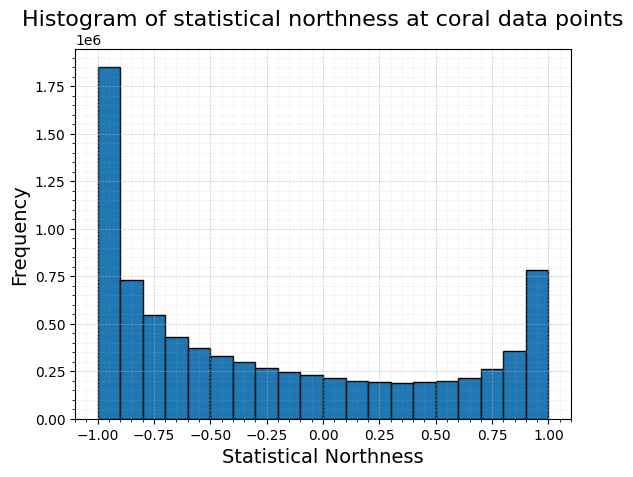

In [17]:
#Plot histogram of statistical northness
plt.hist(statistical_northness, bins=bin_edges_stat_northness, edgecolor='black')
plt.xlabel('Statistical Northness', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Histogram of statistical northness at coral data points', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Main grid
plt.minorticks_on()  # Enable minor ticks
plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)  # Finer minor grid

plt.savefig(f'/cluster/home/maikents/statistical_northness_hourly_histogram_coral_points.png')
 
plt.show()

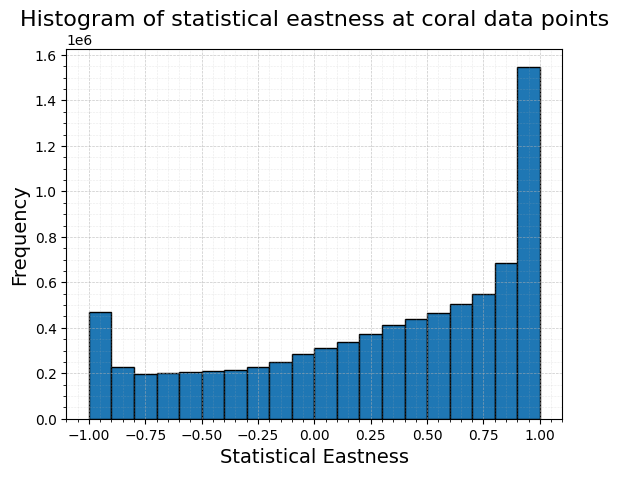

In [15]:
#Plot histogram of statistical eastness
plt.hist(statistical_eastness, bins=bin_edges_stat_eastness, edgecolor='black')
plt.xlabel('Statistical Eastness', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Histogram of statistical eastness at coral data points', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Main grid
plt.minorticks_on()  # Enable minor ticks
plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)  # Finer minor grid

plt.savefig(f'/cluster/home/maikents/statistical_eastness_hourly_histogram_coral_points.png')
 
plt.show()